#### If you are using Google Colab, please, note following steps:
0. Setup colab GPU in two clicks:

 0.1 In `Edit` click on `Notebook settings`
 
 ![](https://github.com/SchattenGenie/mlhep2019_2_phase/blob/master/analysis/colab_gpu_1.png?raw=1)

 0.2 Choose GPU in Hardware accelerator
 
 ![](https://github.com/SchattenGenie/mlhep2019_2_phase/blob/master/analysis/colab_gpu_2.png?raw=1)

In [1]:
#!wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py
#!wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py
#!wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/score.py
#!wget https://github.com/SchattenGenie/mlhep2019_2_phase/raw/master/analysis/embedder.tp

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms 
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm,tnrange,tqdm_notebook
import time
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

#### A bit more steps to setup Google Colab

1. Open this link: https://drive.google.com/open?id=13OVy1GlKFdOW_RjjOtg0AloHjOJMGSrj

2. Add it to your Drive:
![](http://www.digitalchaoscontrol.com/wp-content/uploads/2016/10/AddtoMyDrive.jpg)

3. Uncomment and run following lines of code.

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data pathes

In [5]:
#train_data_path = '/gdrive/My Drive/mlhep2019_gan/data_train.npz'
#val_data_path = '/gdrive/My Drive/mlhep2019_gan/data_val.npz'
#test_data_path = '/gdrive/My Drive/mlhep2019_gan/data_test.npz'

#data paths for folder on my local machine
train_data_path = 'data/data_train.npz'
val_data_path = 'data/data_val.npz'
test_data_path = 'data/data_test.npz'

# Loading data

Data is stored in `.npz`-format which is a special filetype for persisting multiple NumPy arrays on disk. 

More info: https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.format.html#module-numpy.lib.format.

File `dat_train.npz` contains four arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle
  * `ParticlePDG` - particle type(either $e^-$ or $\gamma$)

In [6]:
N = 50250

data_train = np.load(train_data_path, allow_pickle=True)
print(list(data_train.keys()))

# [data_size, 900]
EnergyDeposit = data_train['EnergyDeposit'][:N]
# reshaping it as [data_size, channels, img_size_x, img_size_y]
# channels are needed for pytorch conv2d-layers
EnergyDeposit = EnergyDeposit.reshape(-1, 1, 30, 30)

# [data_size, 3]
ParticleMomentum = data_train['ParticleMomentum'][:N]

# [data_size, 2]
ParticlePoint = data_train['ParticlePoint'][:, :2][:N]

# [data_size, 1]
ParticlePDG = data_train['ParticlePDG'][:N]

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']


## Load it to pytorch `DataLoader`

In [7]:
EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()

BATCH_SIZE = 128
calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [8]:
for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
    break

## Training GAN
###### ...is not a simple matter

It depends on architecture, loss, instance noise, augmentation and even luck(recommend to take a look https://arxiv.org/pdf/1801.04406.pdf)


In this notebook I have prepared some basic parts that you could use for your experiments.

### Three types of losses for GANs

https://medium.com/@jonathan_hui/gan-what-is-wrong-with-the-gan-cost-function-6f594162ce01

There were proposed numerous loss functions to train GANs. In this notebook we have implemented three the most popular choices(but feel free to try other variants!):

### `KL`:


$$\mathcal{L}_g = \log(1 - \mathrm{discriminator}(\mathrm{gen}))$$

$$\mathcal{L}_d = - \log(\mathrm{discriminator}(\mathrm{gen})) - \log(1 - \mathrm{discriminator}(\mathrm{real}))$$


### `REVERSED_KL`

$$\mathcal{L}_g = - \log(\mathrm{discriminator}(\mathrm{gen}))$$

$$\mathcal{L}_d = - \log(\mathrm{discriminator}(\mathrm{gen})) - \log(1 - \mathrm{discriminator}(\mathrm{real}))$$


### `WASSERSTEIN`

$$\mathcal{L}_g = - \mathrm{discriminator}(\mathrm{gen})$$

$$\mathcal{L}_d = \mathrm{discriminator}(\mathrm{gen}) - \mathrm{discriminator}(\mathrm{real})$$

In [9]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN']

TASK = 'WASSERSTEIN'

### Additional things for Wasserstein GAN

To make `Wasserstein`-GAN works we suggest three options:

In [10]:
LIPSITZ_WEIGHTS = False
clamp_lower, clamp_upper = -0.01, 0.01


# https://arxiv.org/abs/1704.00028
GRAD_PENALTY = True

# https://arxiv.org/abs/1705.09367
ZERO_CENTERED_GRAD_PENALTY = False

#### Small hack that can speed-up training and improve generalization

In [11]:
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = True

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

In [12]:
class GANLosses(object):
    def __init__(self, task, device):
        self.TASK = task
        self.device = device
    
    def g_loss(self, discrim_output):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - discrim_output.mean()
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = .1):
        alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
        dims_to_add = len(inp_data.size()) - 2
        for i in range(dims_to_add):
            alpha = alpha.unsqueeze(-1)
        # alpha = alpha.expand(inp_data.size())

        interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

        interpolates.requires_grad = True

        disc_interpolates = discriminator(interpolates, inputs_batch)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

## Defining discriminator

In [13]:
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.lnorm1 = nn.LayerNorm([32,30,30])
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.lnorm2 = nn.LayerNorm([64,14,14])
        self.conv3 = nn.Conv2d(64, 96, 3, padding=1)
        self.lnorm3 = nn.LayerNorm([96,14,14])
        self.conv4 = nn.Conv2d(96, 64, 3, padding=1)
        self.lnorm4 = nn.LayerNorm([64,14,14])
        self.conv5 = nn.Conv2d(64, 32, 3, padding=1)
        self.lnorm5 = nn.LayerNorm([32,14,14])
        self.conv6 = nn.Conv2d(32, 24, 3)
        self.lnorm6 = nn.LayerNorm([24,12,12])
                     
        # size
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(3461, 3500) 
        self.fc2 = nn.Linear(3500, 3000)
        self.fc3 = nn.Linear(3000, 3000)
        self.fc4 = nn.Linear(3000, 1600)
        self.fc5 = nn.Linear(1600, 800)
        self.fc6 = nn.Linear(800, 400)
        self.fc7 = nn.Linear(400, 400)
        self.fc8 = nn.Linear(400,200)
        self.fc9 = nn.Linear(200,100)
        self.fc10 = nn.Linear(100, 50)
        self.fc11 = nn.Linear(50,30)
        self.fc12 = nn.Linear(30,1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        if TASK == 'WASSERSTEIN':
            ### WGAN, no Batch Norm
            EnergyDeposit = self.dropout(F.leaky_relu(self.lnorm1(self.conv1(EnergyDeposit))))
            EnergyDeposit = self.dropout(F.leaky_relu(self.lnorm2(self.conv2(EnergyDeposit))))  
            EnergyDeposit = self.dropout(F.leaky_relu(self.lnorm3(self.conv3(EnergyDeposit)))) 
            EnergyDeposit = self.dropout(F.leaky_relu(self.lnorm4(self.conv4(EnergyDeposit)))) 
            EnergyDeposit = self.dropout(F.leaky_relu(self.lnorm5(self.conv5(EnergyDeposit)))) 
        else:
            ### Non WGAN, use Batch norm
            EnergyDeposit = self.dropout(F.leaky_relu(self.bn1(self.conv1(EnergyDeposit))))
            EnergyDeposit = self.dropout(F.leaky_relu(self.bn2(self.conv2(EnergyDeposit))))
        ### Rest of disc/critic
        EnergyDeposit = F.leaky_relu(self.lnorm6(self.conv6(EnergyDeposit))) # 32, 9, 9
        EnergyDeposit = EnergyDeposit.view(len(EnergyDeposit), -1)
        
        t = torch.cat([EnergyDeposit, ParticleMomentum_ParticlePoint], dim=1)
        
        t = self.dropout2(F.leaky_relu(self.fc1(t)))
        t = self.dropout2(F.leaky_relu(self.fc2(t)))
        t = self.dropout2(F.leaky_relu(self.fc3(t)))
        t = self.dropout2(F.leaky_relu(self.fc4(t)))
        t = self.dropout2(F.leaky_relu(self.fc5(t)))
        t = self.dropout2(F.leaky_relu(self.fc6(t)))
        t = self.dropout2(F.leaky_relu(self.fc7(t)))
        t = self.dropout2(F.leaky_relu(self.fc8(t)))
        t = self.dropout2(F.leaky_relu(self.fc9(t)))
        t = self.dropout2(F.leaky_relu(self.fc10(t)))
        t = self.dropout2(F.leaky_relu(self.fc11(t)))
        if TASK == 'WASSERSTEIN':
            return self.fc12(t)
        else:
            return torch.sigmoid(self.fc12(t))

In [14]:
# Deisc for my record
# class ModelD(nn.Module):
#     def __init__(self):
#         super(ModelD, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.dropout = nn.Dropout(p=0.3)
#         self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 64, 3)
#         self.conv4 = nn.Conv2d(64, 32, 3)
                
#         # size
#         self.fc1 = nn.Linear(2592 + 5, 1024) 
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 256)
#         self.fc4 = nn.Linear(256, 128)
#         self.fc5 = nn.Linear(128, 64)
#         self.fc6 = nn.Linear(64, 1)
        
#     def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
#         if TASK == 'WASSERSTEIN':
#             ### WGAN, no Batch Norm
#             EnergyDeposit = self.dropout(F.leaky_relu((self.conv1(EnergyDeposit))))
#             EnergyDeposit = self.dropout(F.leaky_relu(self.conv2(EnergyDeposit)))   
#         else:
#             ### Non WGAN, use Batch norm
#             EnergyDeposit = self.dropout(F.leaky_relu(self.bn1(self.conv1(EnergyDeposit))))
#             EnergyDeposit = self.dropout(F.leaky_relu(self.bn2(self.conv2(EnergyDeposit))))
#         ### Rest of disc/critic
#         EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
#         EnergyDeposit = F.leaky_relu(self.conv4(EnergyDeposit)) # 32, 9, 9
#         EnergyDeposit = EnergyDeposit.view(len(EnergyDeposit), -1)
        
#         t = torch.cat([EnergyDeposit, ParticleMomentum_ParticlePoint], dim=1)
        
#         t = F.leaky_relu(self.fc1(t))
#         t = F.leaky_relu(self.fc2(t))
#         t = F.leaky_relu(self.fc3(t))
#         t = F.leaky_relu(self.fc4(t))
#         t = F.leaky_relu(self.fc5(t))
#         if TASK == 'WASSERSTEIN':
#             return self.fc6(t)
#         else:
#             return torch.sigmoid(self.fc6(t))

## Defining generator

In [15]:
class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + 2 + 3, 512)
        self.dense_norm1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1024)
        self.dense_norm2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.dense_norm3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 4096)
        self.dense_norm4 = nn.BatchNorm1d(4096)
        self.fc5 = nn.Linear(4096, 8192)
        self.dense_norm5 = nn.BatchNorm1d(8192)
        self.fc6 = nn.Linear(8192, 8192)
        self.dense_norm6 = nn.BatchNorm1d(8192)
        self.fc7 = nn.Linear(8192, 8192)
        self.dense_norm7 = nn.BatchNorm1d(8192)
        self.fc8 = nn.Linear(8192, 20736)
        self.dense_norm8 = nn.BatchNorm1d(20736)
        
        #ConvTranspose can introduce artifacts in upscaling, old model, got high score 0.5366 on 13.08
        #self.conv1 = nn.ConvTranspose2d(256, 256, 3, stride=2, output_padding=1)
        #self.conv2 = nn.ConvTranspose2d(256, 128, 3)
        #self.conv3 = nn.ConvTranspose2d(128, 64, 3)
        #self.conv4 = nn.ConvTranspose2d(64, 32, 3)
        #self.conv5 = nn.ConvTranspose2d(32, 16, 3)
        #self.conv6 = nn.ConvTranspose2d(16, 1, 3)
        
        # Using upsample, conv2d and reflectionpad to increase the image size, 
        self.refpad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, 1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, 1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, 1)
        self.conv7 = nn.Conv2d(32, 32 ,3, padding=1)
        self.conv8 = nn.Conv2d(32, 16, 1)
        self.conv9 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv10 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv11 = nn.Conv2d(16, 1, 3, padding=1)
        self.upscale1 = nn.Upsample(size=(18,18), mode='nearest')
        self.upscale2 = nn.Upsample(size=(30,30), mode='nearest')
        
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = F.leaky_relu(self.dense_norm1(self.fc1(
            torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        )))
        x = F.leaky_relu(self.dense_norm2(self.fc2(x)))
        x = F.leaky_relu(self.dense_norm3(self.fc3(x)))
        x = F.leaky_relu(self.dense_norm4(self.fc4(x)))
        x = F.leaky_relu(self.dense_norm5(self.fc5(x)))
        x = F.leaky_relu(self.dense_norm6(self.fc6(x)))
        x = F.leaky_relu(self.dense_norm7(self.fc7(x)))
        x = F.leaky_relu(self.dense_norm8(self.fc8(x)))
        
        EnergyDeposit = x.view(-1, 256, 9, 9)
        
        #EnergyDeposit = self.refpad(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.conv1(EnergyDeposit))
        EnergyDeposit = self.upscale1(EnergyDeposit)
        #EnergyDeposit = self.refpad(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.conv1(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv2(EnergyDeposit))
        EnergyDeposit = self.upscale2(EnergyDeposit)
        #EnergyDeposit = self.refpad(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv4(EnergyDeposit))
        #EnergyDeposit = self.refpad(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.conv5(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv6(EnergyDeposit))
        #EnergyDeposit = self.refpad(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.conv7(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv8(EnergyDeposit))
        #EnergyDeposit = self.refpad(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.conv9(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv10(EnergyDeposit))
        EnergyDeposit = self.conv11(EnergyDeposit)
        
        #old model, got high score 0.5366 on 13.08
        #EnergyDeposit = F.leaky_relu(self.conv1(EnergyDeposit))
        #EnergyDeposit = F.leaky_relu(self.conv2(EnergyDeposit))
        #EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        #EnergyDeposit = F.leaky_relu(self.conv4(EnergyDeposit))
        #EnergyDeposit = F.leaky_relu(self.conv5(EnergyDeposit))
        #EnergyDeposit = self.conv6(EnergyDeposit)

        return EnergyDeposit

## Check our models on one batch 

In [16]:
NOISE_DIM = 1000

discriminator = ModelD().to(device)
generator = ModelGConvTranspose(z_dim=NOISE_DIM).to(device)

In [17]:
#EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
#                                                        ParticleMomentum_b.to(device), \
#                                                        ParticlePoint_b.to(device)
#ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)


In [18]:
#EnergyDeposit_b.shape
#ParticleMomentum_ParticlePoint_b.shape

In [19]:
#discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape

In [20]:
#noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
#generator(noise, ParticleMomentum_ParticlePoint_b).shape

## Defining optimiser

In [21]:
learning_rate_dis = 1e-5
learning_rate_gen = 1e-5

#g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_gen, weight_decay=1e-6)
#d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)

g_optimizer = optim.RMSprop(generator.parameters(), lr=learning_rate_gen, weight_decay=1e-5)
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-5)

## Initialize weights

In [22]:
def init_weights(net):
    with torch.no_grad(): 
        if type(net) == nn.Linear:
            torch.nn.init.xavier_normal_(net.weight)
            net.bias.data.fill_(0.001)
        if type(net) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(net.weight)
            net.bias.data.fill_(0.001)
        if type(net) == nn.ConvTranspose2d:
            torch.nn.init.xavier_uniform_(net.weight)
            net.bias.data.fill_(0.001)
        
discriminator.apply(init_weights)
generator.apply(init_weights)

ModelGConvTranspose(
  (fc1): Linear(in_features=1005, out_features=512, bias=True)
  (dense_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (dense_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=2048, bias=True)
  (dense_norm3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=2048, out_features=4096, bias=True)
  (dense_norm4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=4096, out_features=8192, bias=True)
  (dense_norm5): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=8192, out_features=8192, bias=True)
  (dense_norm6): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f

## Save or Load Model Parameters

In [23]:
# Loading weights after training for image generation
Load_Parameters = False

# Resume training from a checkpoint
Resume_Training = False
# Otherwise start training from scratch

# Save parameters after training
Save_Parameters = True

## Load scores

In [24]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

In [25]:
dis_epoch_loss = []
gen_epoch_loss = []
predictions_dis = []
predictions_gen = []
prd_auc = [] 

def run_training(epochs, start=0):

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = 10, 1

    gan_losses = GANLosses(TASK, device)
    #transforming = transforms.RandomErasing(p=0.7,scale=(0.02,0.1))
                
    for epoch in tqdm(range(start, epochs)):
        first = True
        
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            #with torch.no_grad():    
            #    for i, pic in enumerate(EnergyDeposit_b):
            #        EnergyDeposit_b[i] = transforming(pic)
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device)
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
            if first:
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                predictions_dis.append(
                    list(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )

                predictions_gen.append(
                    list(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )
            # Optimize D
            for _ in range(k_d):
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
    
                if INSTANCE_NOISE:
                    EnergyDeposit_b = add_instance_noise(EnergyDeposit_b)
                    EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
                    
                loss = gan_losses.d_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b),
                                         discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b))
                if GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_gradient_penalty(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_b.data)
                    loss += grad_penalty
                    
                elif ZERO_CENTERED_GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_zero_centered_GP(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_b.data)
                    loss -= grad_penalty

                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                if LIPSITZ_WEIGHTS:                    
                    [p.data.clamp_(clamp_lower, clamp_upper) for p in discriminator.parameters()]

            dis_epoch_loss.append(loss.item())

            # Optimize G
            for _ in range(k_g):
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                
                if INSTANCE_NOISE:
                    EnergyDeposit_b = add_instance_noise(EnergyDeposit_b)
                    EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
                
                loss = gan_losses.g_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
                
            gen_epoch_loss.append(loss.item())
            if first:
                precision, recall = compute_prd_from_embedding(
                    EnergyDeposit_gen.detach().cpu().numpy().reshape(BATCH_SIZE, -1), 
                    EnergyDeposit_b.detach().cpu().numpy().reshape(BATCH_SIZE, -1),
                    num_clusters=30,
                    num_runs=100)
                prd_auc.append(auc(precision, recall))
                first = False
        
        clear_output()
        plt.figure(figsize=(12, 12))
        plt.plot(dis_epoch_loss, label='dis_epoch_loss')
        plt.plot(gen_epoch_loss, label='gen_epoch_loss')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12, 12))
        plt.hist(predictions_dis[-1], bins=100, label='dis_prediction')
        plt.hist(predictions_gen[-1], bins=100, label='gen_prediction')
        plt.legend()
        plt.show()
        print(np.mean(predictions_dis[-1]), np.mean(predictions_gen[-1]))
        
        plt.figure(figsize=(12, 12))
        plt.plot(prd_auc, label='prd_auc')
        plt.plot()
        plt.legend()
        plt.show()

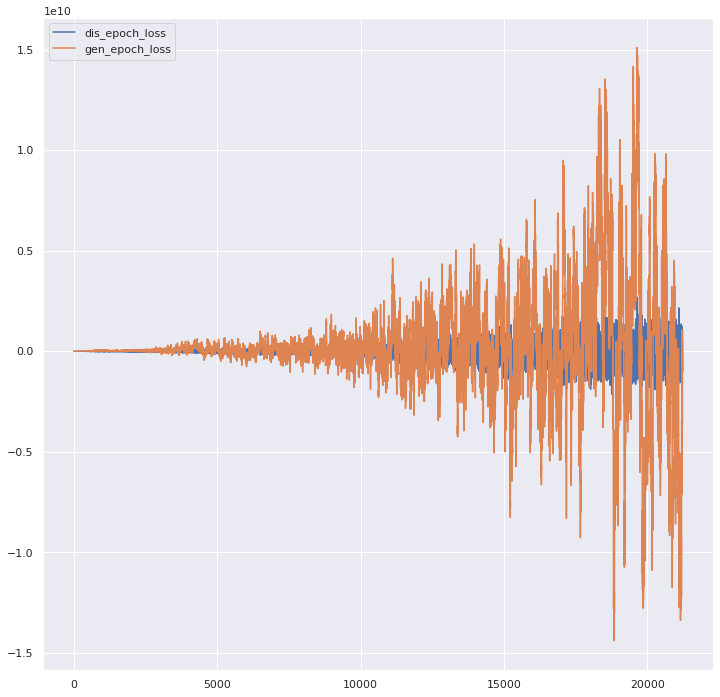

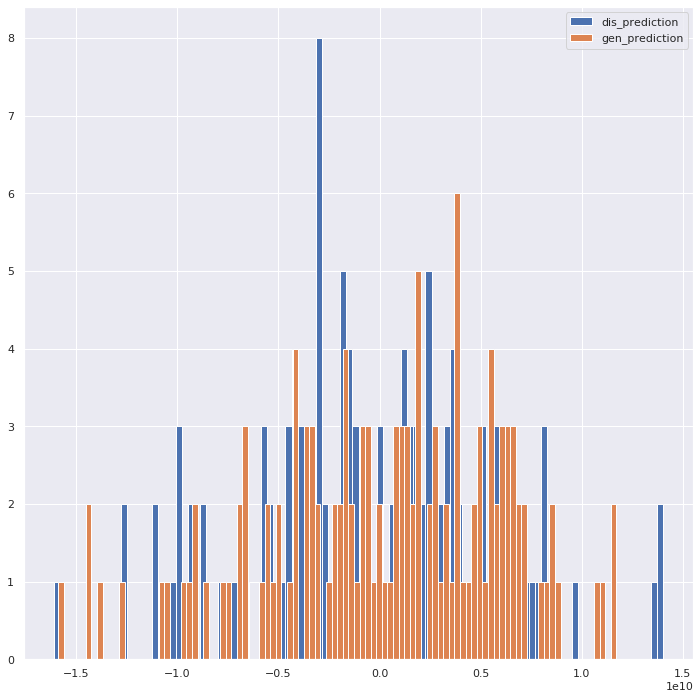

-520962050.0 168056980.0


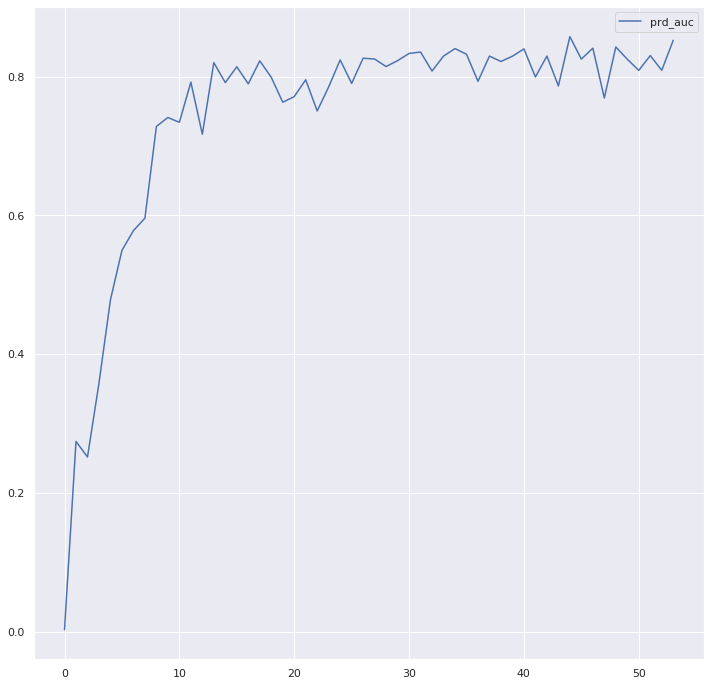

  1%|▏         | 54/4000 [17:52:18<1306:16:59, 1191.74s/it]

KeyboardInterrupt: 

In [26]:
if Load_Parameters: #Loading weights after training for image generation
    g_checkpoint = torch.load('./generator_params0110.pt')
    generator.load_state_dict(g_checkpoint['model_state_dict'])
    generator.eval()
    d_checkpoint = torch.load('./discriminator0110_params.pt')
    discriminator.load_state_dict(d_checkpoint['model_state_dict'])
    discriminator.eval()

    dis_epoch_loss = d_checkpoint['loss']
    gen_epoch_loss = g_checkpoint['loss']
    prd_auc = g_checkpoint['prd_auc']
    predictions_dis = d_checkpoint['prediction']
    predictions_gen = g_checkpoint['prediction']
    
    

elif Resume_Training: #Resume training from a checkpoint
    g_checkpoint = torch.load('./generator_params.pt')
    generator.load_state_dict(g_checkpoint['model_state_dict'])
    g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
    startepoch = g_checkpoint['epoch']
    gen_epoch_loss = g_checkpoint['loss']
    prd_auc = g_checkpoint['prd_auc']
    predictions_gen = g_checkpoint['prediction']
    generator.eval()
    generator.train()
    torch.cuda.empty_cache()
                                                                                         
    d_checkpoint = torch.load('./discriminator_params.pt')
    discriminator.load_state_dict(d_checkpoint['model_state_dict'])
    d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dict'])
    dis_epoch_loss = d_checkpoint['loss']
    predictions_dis = d_checkpoint['prediction']
    discriminator.eval()
    discriminator.train()
    torch.cuda.empty_cache()
    
    run_training(4000, start=startepoch)
              
        
        
else: #Start training from scratch
    run_training(4000)

In [ ]:
if Load_Parameters:
         
    plt.figure(figsize=(12, 12))
    plt.plot(dis_epoch_loss, label='dis_epoch_loss')
    plt.plot(gen_epoch_loss, label='gen_epoch_loss')
    plt.legend()    
    plt.savefig("wgan_loss.pdf")  
    
    
    plt.show()    
    plt.figure(figsize=(12, 12))
    plt.hist(predictions_dis[-1], bins=100, label='dis_prediction')
    plt.hist(predictions_gen[-1], bins=100, label='gen_prediction')
    plt.legend()
    plt.savefig("pred.pdf")
    plt.show()
    print(np.mean(predictions_dis[-1]), np.mean(predictions_gen[-1]))
        
    plt.figure(figsize=(12, 12))
    plt.plot(prd_auc, label='prd_auc')
    plt.plot()
    plt.legend()
    plt.savefig("prd_auc.pdf")
    plt.show()

In [27]:
if Save_Parameters:
    torch.save({'model_state_dict' : generator.state_dict(),
                'optimizer_state_dict' : g_optimizer.state_dict(),
                'epoch' : len(prd_auc)-1,
                'loss' : gen_epoch_loss,
                'prediction' : predictions_gen,
                'prd_auc' : prd_auc
               }, './generator_params.pt')
    
    torch.save({'model_state_dict' : discriminator.state_dict(),
                'optimizer_state_dict' : d_optimizer.state_dict(),
                'loss' : dis_epoch_loss,
                'prediction' : predictions_dis
                }, './discriminator_params.pt')
    

#### Transfer generator on CPU:

In [28]:
generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
generator_cpu.load_state_dict(generator.state_dict())
generator_cpu.eval()
generator_cpu.train(False)

ModelGConvTranspose(
  (fc1): Linear(in_features=1005, out_features=512, bias=True)
  (dense_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (dense_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=2048, bias=True)
  (dense_norm3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=2048, out_features=4096, bias=True)
  (dense_norm4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=4096, out_features=8192, bias=True)
  (dense_norm5): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=8192, out_features=8192, bias=True)
  (dense_norm6): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f

## Making predictions

#### Validation predictions

In [29]:
data_val = np.load(val_data_path, allow_pickle=True)
ParticleMomentum_val = torch.tensor(data_val['ParticleMomentum']).float()
ParticlePoint_val = torch.tensor(data_val['ParticlePoint'][:, :2]).float()
ParticleMomentum_ParticlePoint_val = torch.cat([ParticleMomentum_val, ParticlePoint_val], dim=1)
calo_dataset_val = utils.TensorDataset(ParticleMomentum_ParticlePoint_val)
calo_dataloader_val = torch.utils.data.DataLoader(calo_dataset_val, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_val = []
    for ParticleMomentum_ParticlePoint_val_batch in tqdm_notebook(calo_dataloader_val):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_val_batch[0]), NOISE_DIM)
        EnergyDeposit_val_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_val_batch[0]).detach().numpy()
        EnergyDeposit_val.append(EnergyDeposit_val_batch)
    np.savez_compressed('./data_val_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0))

    del EnergyDeposit_val
del data_val; del ParticleMomentum_val; del ParticlePoint_val; del ParticleMomentum_ParticlePoint_val;
del calo_dataset_val; calo_dataloader_val

#### Test predictions

In [30]:
data_test = np.load(test_data_path, allow_pickle=True)
ParticleMomentum_test = torch.tensor(data_test['ParticleMomentum']).float()
ParticlePoint_test = torch.tensor(data_test['ParticlePoint'][:, :2]).float()
ParticleMomentum_ParticlePoint_test = torch.cat([ParticleMomentum_test, ParticlePoint_test], dim=1)
calo_dataset_test = utils.TensorDataset(ParticleMomentum_ParticlePoint_test)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_test = []
    for ParticleMomentum_ParticlePoint_test_batch in tqdm_notebook(calo_dataloader_test):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_test_batch[0]), NOISE_DIM)
        EnergyDeposit_test_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_test_batch[0]).detach().numpy()
        EnergyDeposit_test.append(EnergyDeposit_test_batch)
    np.savez_compressed('./data_test_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_test, axis=0))

    del EnergyDeposit_test
del data_test; del ParticleMomentum_test; del ParticlePoint_test; del ParticleMomentum_ParticlePoint_test;
del calo_dataset_test; calo_dataloader_test

## `zip-zip` files together

In [31]:
!zip solution.zip data_val_prediction.npz data_test_prediction.npz

updating: data_val_prediction.npz (deflated 0%)
updating: data_test_prediction.npz (deflated 0%)


In [32]:
from IPython.display import FileLink
FileLink('./solution.zip')

/media/j_hone04/DATA/MLHEP19_Competition/solution.zip

# A few words about metrics

### Lets generate some fake data

In [33]:
EnergyDeposit_batch, ParticleMomentum_batch, ParticlePoint_batch =  next(iter(calo_dataloader))

noise = torch.randn(len(ParticleMomentum_batch), NOISE_DIM)
ParticleMomentum_ParticlePoint = torch.cat([ParticleMomentum_batch, 
                                            ParticlePoint_batch], dim=1)
#EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint)
#with torch.no_grad():
    #EnergyDeposit_gen = generator(noise.to('cuda'), ParticleMomentum_ParticlePoint.to('cuda'))
EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint)

In [34]:
EnergyDeposit_gen = EnergyDeposit_gen.detach().cpu().numpy().reshape(-1,30, 30)
EnergyDeposit = EnergyDeposit.detach().cpu().numpy().reshape(-1, 30, 30)

In [35]:
EnergyDeposit_gen.shape

(128, 30, 30)

#### Plot one image

In [36]:
def plot_images(images: np.ndarray, filename: str="filename.pdf", nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
#     """
#     Plots a subset of images.
  
#     Args:
#         images[n_images, n_channels, width, height]: a dataset with images to plot
#         nrows: number of images in a plotted row
#         ncols: numer of images in a plotted colunm
#         shuffle: if True draw a random subset of images, if False -- the first ones
#         figure: if not None, it's used for plotting, if None, a new one is created
        
#     Returns:
#         a figure containing the plotted images
#     """
    if shuffle:
        images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
    else:
        images_to_plot = images[:nrows * ncols]
    h, w = images_to_plot.shape[1:]
    if figure is None:
        figure = plt.figure(figsize=(16,16))
    axes = figure.subplots(nrows=nrows, ncols=ncols)
    figure.subplots_adjust(left=0.02, bottom=0.06, right=0.98, top=0.94, wspace=0.3)
    for row_idx, ax_row in enumerate(axes):
        for col_idx, ax in enumerate(ax_row):
            im = ax.imshow(images_to_plot[row_idx + ncols*col_idx].transpose(0, 1),
                      interpolation="none")
            figure.colorbar(im , ax=ax)
    figure.savefig(filename)
    #return figure

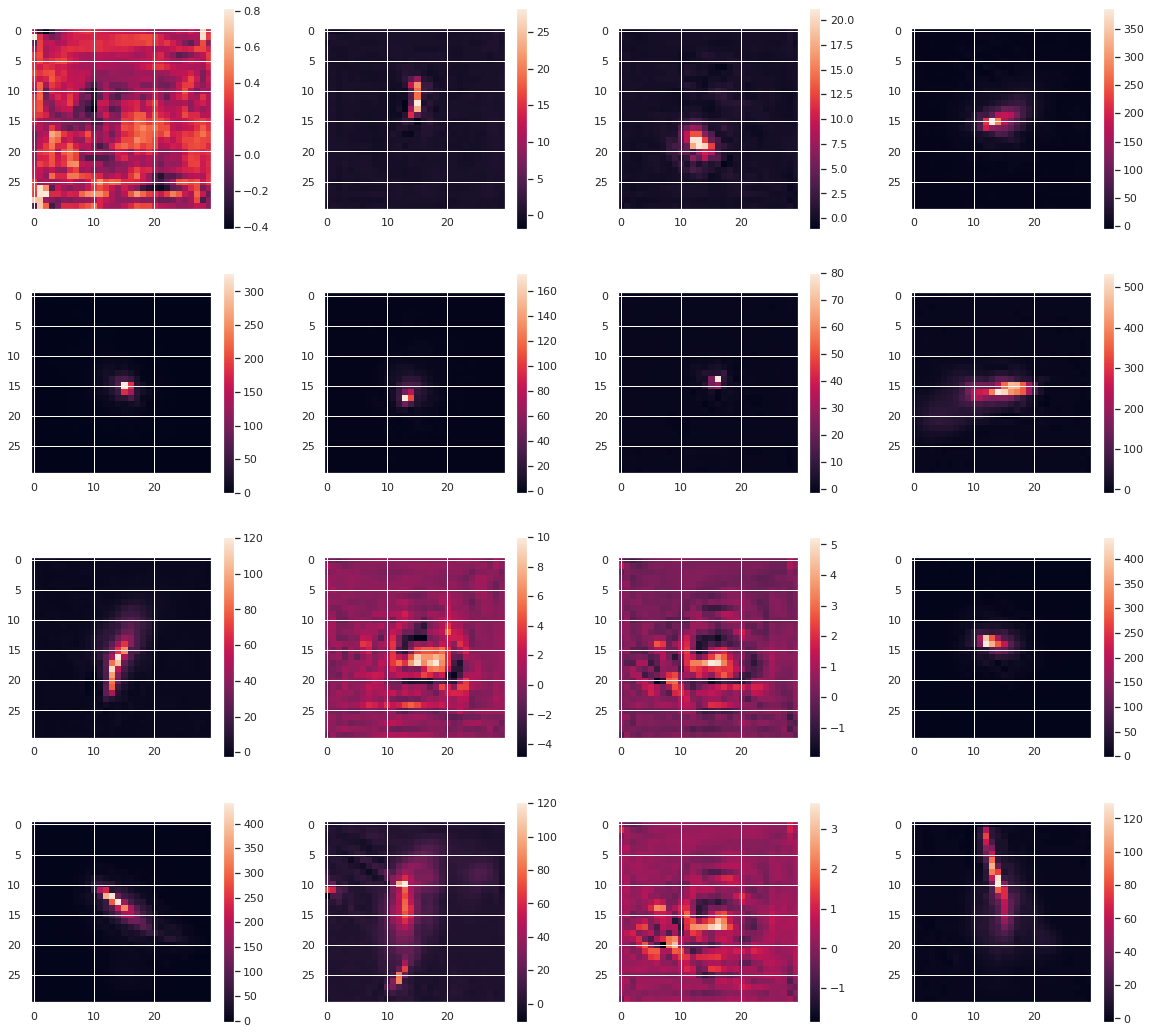

In [39]:
plot_images(EnergyDeposit_gen, "edeposit_gen.pdf", 4, 4)

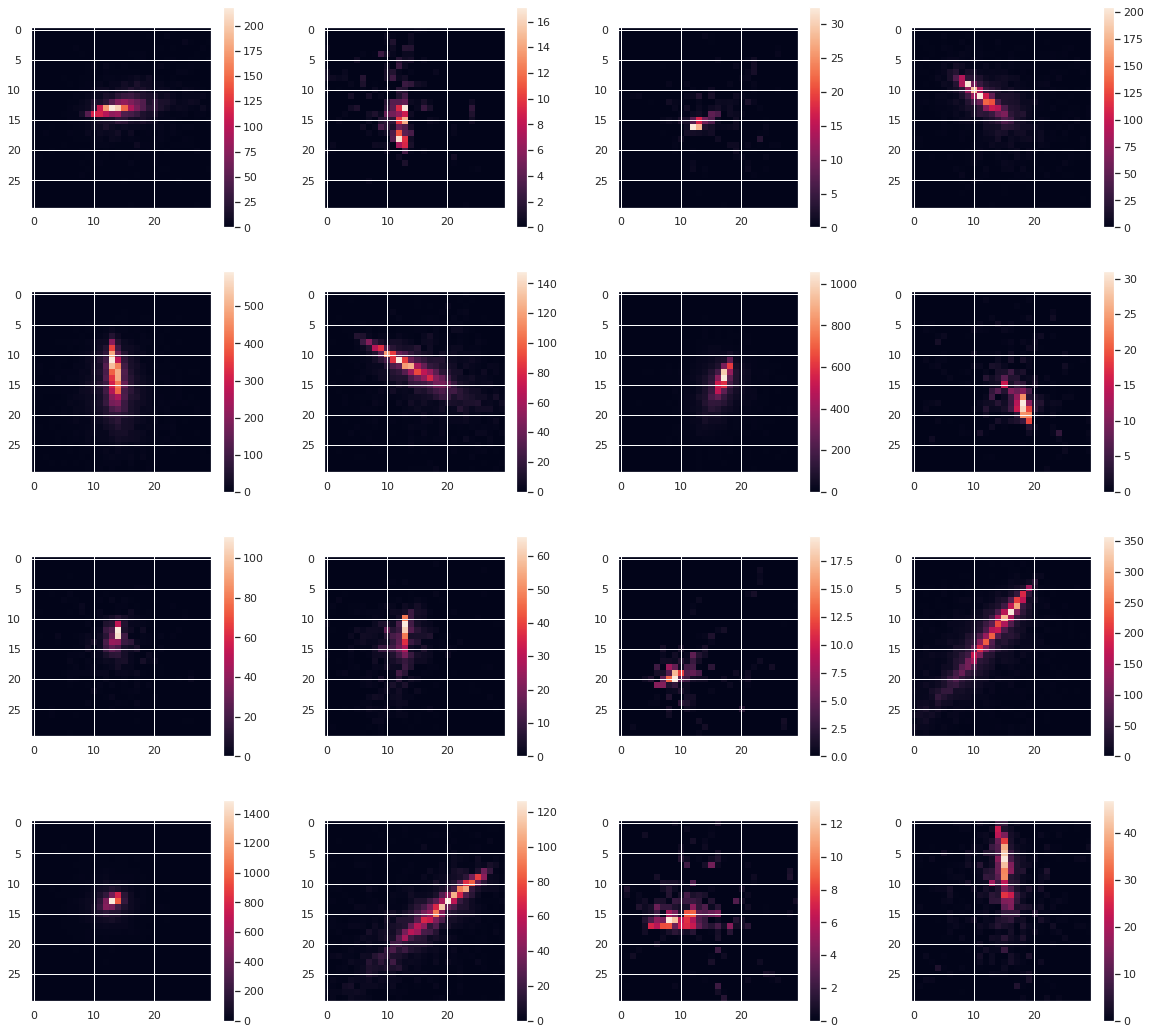

In [38]:
plot_images(EnergyDeposit, "edeposit.pdf", 4, 4)

## Calculate PRD score between these batch 

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.batchnorm0 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256, 256) 
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 3)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x), self.fc5(x)
    
    def get_encoding(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

def load_embedder(path):
    embedder = torch.load(path)
    embedder.eval()
    return embedder

embedder = load_embedder('./embedder.tp')

In [ ]:
data_real = embedder.get_encoding(torch.tensor(EnergyDeposit_batch).float().view(-1, 1, 30, 30)).detach().numpy()
data_fake = embedder.get_encoding(torch.tensor(EnergyDeposit_gen).float().view(-1, 1, 30, 30)).detach().numpy()

In [ ]:
def plot_pr_aucs(precisions, recalls):
    plt.figure(figsize=(12, 12))
    pr_aucs = []
    for i in range(len(recalls)):
        plt.step(recalls[i], precisions[i], color='b', alpha=0.2,  label='PR-AUC={}'.format(auc(precisions[i], recalls[i])))
        pr_aucs.append(auc(precisions[i], recalls[i]))
    plt.step(np.mean(recalls, axis=0), np.mean(precisions, axis=0), color='r', alpha=1,  label='average')
    plt.fill_between(np.mean(recalls, axis=0), 
                     np.mean(precisions, axis=0) - np.std(precisions, axis=0) * 3,
                     np.mean(precisions, axis=0) + np.std(precisions, axis=0) * 3, color='g', alpha=0.2,  label='std')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    print(np.mean(pr_aucs), np.std(pr_aucs))
    plt.legend()
    
    return pr_aucs

def calc_pr_rec(data_real, data_fake, num_clusters=20, num_runs=10, NUM_RUNS=10):
    precisions = []
    recalls = []
    for i in tqdm_notebook(range(NUM_RUNS)):
        precision, recall = compute_prd_from_embedding(data_real, data_fake, num_clusters=num_clusters, num_runs=num_runs)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

In [ ]:
precisions, recalls = calc_pr_rec(data_real, data_fake, num_clusters=100, num_runs=20)

In [ ]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [ ]:
pr_aucs

## Physical metrics

In [ ]:
import matplotlib.lines as mlines
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def plot_axes_for_shower(ecal, point, p):
    x = np.linspace(-14.5, 14.5, 30)
    y = np.linspace(-14.5, 14.5, 30)

    xx, yy = np.meshgrid(x, y)
    zoff = 25.
    ipic = 3
    orth = np.array([-p[1], p[0]])

    pref = point[:2] + p[:2] * zoff / p[2]

    p1 = pref - 10 * p[:2]
    p2 = pref + 10 * p[:2]
    p3 = pref - 10 * orth
    p4 = pref + 10 * orth

    plt.contourf(xx, yy, np.log(ecal + 1), cmap=plt.cm.inferno)
    newline(p1, p2)
    newline(p3, p4)
    plt.colorbar()

In [ ]:
idx = 2
plot_axes_for_shower(EnergyDeposit[idx], point=ParticlePoint[idx].detach().numpy(),
                     p=ParticleMomentum[idx].detach().numpy())

In [ ]:
from calogan_metrics import get_assymetry, get_shower_width, get_sparsity_level

In [ ]:
assym = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
assym_ortho = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sh_width = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
sh_width_ortho = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sparsity_level = get_sparsity_level(EnergyDeposit)

## Longitudual cluster asymmetry

In [ ]:
sns.set(font_scale=2)
plt.hist(assym, bins=50, range=[-1, 1], color='red', alpha=0.3, density=True, label='MC');
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')

## Transverse cluster asymmetry

In [ ]:
sns.set(font_scale=2)
plt.hist(assym_ortho, bins=50, range=[-1, 1], color='red', alpha=0.3, density=True, label='MC');
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')

## Cluster longitudual width

In [ ]:
plt.hist(sh_width, bins=50, range=[0, 15], density=True, alpha=0.3, color='red', label='MC');
plt.title('Shower longitudial width')
plt.legend(loc='best')
plt.xlabel('Cluster longitudual width [cm]')
plt.ylabel('Arbitrary units')

## Cluster trasverse width

In [ ]:
plt.hist(sh_width_ortho, bins=50, range=[0,10], density=True, alpha=0.3, color='blue', label='MC');
#plt.title('Shower transverse width')
plt.legend(loc='best')
plt.xlabel('Cluster trasverse width [cm]')
plt.ylabel('Arbitrary units')

## Sparsity

In [ ]:
alphas = np.log(np.logspace(-5, -1, 20))
means_r = np.mean(sparsity_level, axis=1)
stddev_r = np.std(sparsity_level, axis=1)

In [ ]:
plt.plot(alphas, means_r, color='red')
plt.fill_between(alphas, means_r-stddev_r, means_r+stddev_r, color='red', alpha=0.3)
plt.legend(['MC'])
plt.title('Sparsity')
plt.xlabel('log10(Threshold/GeV)')
plt.ylabel('Fraction of cells above threshold')

In [ ]:
from calogan_metrics import get_physical_stats
real_phys_stats = get_physical_stats(EnergyDeposit_batch, ParticleMomentum_batch.detach().numpy(), ParticlePoint_batch.detach().numpy())
gen_phys_stats = get_physical_stats(EnergyDeposit_gen, ParticleMomentum_batch.detach().numpy(), ParticlePoint_batch.detach().numpy())

In [ ]:
precisions, recalls = calc_pr_rec(real_phys_stats, gen_phys_stats, num_clusters=100, num_runs=20)

In [ ]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [ ]:
pr_aucs